<a href="https://colab.research.google.com/github/josimardtm/MIEL/blob/main/Tutorial03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3 para el uso de Pandapower en el Curso de Microrredes Eléctricas 2025-1

## Instalar Pandapower con sus dependencias

In [23]:
# Instalación de Pandapower con todas las dependencias necesarias
!pip install pandapower[all]

ERROR: Operation cancelled by user


## Creación de la Red Simple

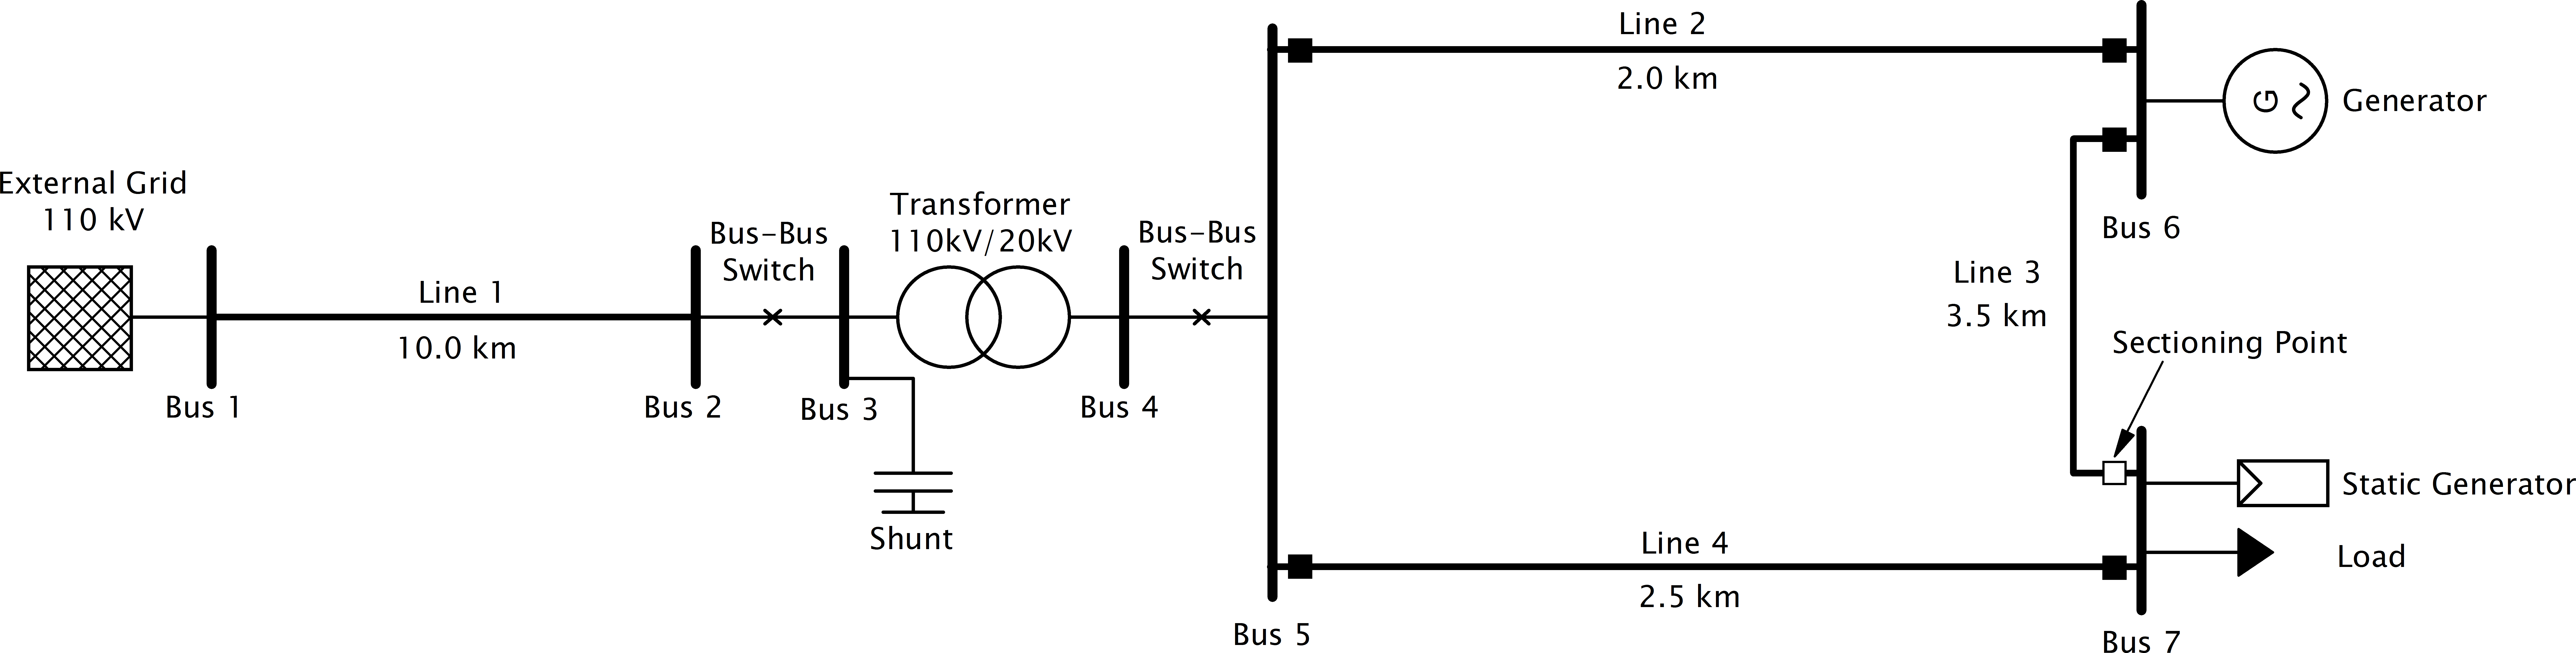

In [24]:
import pandapower as pp #import pandapower

net = pp.create_empty_network() # crear red vacía

# nodos
bus1 = pp.create_bus(net, name="HV Busbar", vn_kv=110, type="b")
bus2 = pp.create_bus(net, name="HV Busbar 2", vn_kv=110, type="b")
bus3 = pp.create_bus(net, name="HV Transformer Bus", vn_kv=110, type="n")
bus4 = pp.create_bus(net, name="MV Transformer Bus", vn_kv=20, type="n")
bus5 = pp.create_bus(net, name="MV Main Bus", vn_kv=20, type="b")
bus6 = pp.create_bus(net, name="MV Bus 1", vn_kv=20, type="b")
bus7 = pp.create_bus(net, name="MV Bus 2", vn_kv=20, type="b")

pp.create_ext_grid(net, bus1, vm_pu=1.02, va_degree=50) # crear conexión de red externa

trafo1 = pp.create_transformer(net, bus3, bus4, name="110kV/20kV transformer", std_type="25 MVA 110/20 kV") # crear transformador

# líneas
line1 = pp.create_line(net, bus1, bus2, length_km=10, std_type="N2XS(FL)2Y 1x300 RM/35 64/110 kV",  name="Line 1")
line2 = pp.create_line(net, bus5, bus6, length_km=2.0, std_type="NA2XS2Y 1x240 RM/25 12/20 kV", name="Line 2")
line3 = pp.create_line(net, bus6, bus7, length_km=3.5, std_type="48-AL1/8-ST1A 20.0", name="Line 3")
line4 = pp.create_line(net, bus7, bus5, length_km=2.5, std_type="NA2XS2Y 1x240 RM/25 12/20 kV", name="Line 4")

# interruptores
sw1 = pp.create_switch(net, bus2, bus3, et="b", type="CB", closed=True)
sw2 = pp.create_switch(net, bus4, bus5, et="b", type="CB", closed=True)
sw3 = pp.create_switch(net, bus5, line2, et="l", type="LBS", closed=True)
sw4 = pp.create_switch(net, bus6, line2, et="l", type="LBS", closed=True)
sw5 = pp.create_switch(net, bus6, line3, et="l", type="LBS", closed=True)
sw6 = pp.create_switch(net, bus7, line3, et="l", type="LBS", closed=False)
sw7 = pp.create_switch(net, bus7, line4, et="l", type="LBS", closed=True)
sw8 = pp.create_switch(net, bus5, line4, et="l", type="LBS", closed=True)

# cargas
pp.create_load(net, bus7, p_mw=2, q_mvar=4, scaling=0.6, name="load")
pp.create_load(net, bus7, p_mw=2, q_mvar=4, const_z_percent=30, const_i_percent=20, name="zip_load")

# generadores
pp.create_sgen(net, bus7, p_mw=2, q_mvar=-0.5, name="Solar Plant") # generación estática
pp.create_gen(net, bus6, p_mw=6, max_q_mvar=3, min_q_mvar=-3, vm_pu=1.03, name="generator")
pp.create_shunt(net, bus3, q_mvar=-0.96, p_mw=0, name='Shunt')

print(net)

This pandapower network includes the following parameter tables:
   - bus (7 elements)
   - load (2 elements)
   - sgen (1 element)
   - gen (1 element)
   - switch (8 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (4 elements)
   - trafo (1 element)


## Configuración de la serie de tiempo

In [25]:
import pandapower.control as control
import pandapower.timeseries as timeseries
from pandapower.timeseries.data_sources.frame_data import DFData
import pandas as pd
import numpy as np

# Definir una serie de tiempo para la potencia en la primera carga
n_ts = 200  # Number of time steps
time_series = pd.DataFrame(
    np.random.uniform(0.5, 2.0, size=(n_ts, 1)),  # crear un perfil aleatorio entre 0.5y 2 MW
    columns=[0]  # corresponde al primer índice en la tabla de cargas
)

# Crear una data source a partir del DataFrame
ds = DFData(time_series)

# Se aplica la serie de tiempos a la primera carga
control.ConstControl(
    net,
    element="load",
    element_index=[0],  # índice de la primera carga
    variable="p_mw",
    data_source=ds,
    profile_name=[0]
)

# Se configura el OutputWriter para guardar las respuestas
ow = timeseries.OutputWriter(net, output_path="./", output_file_type=".xlsx")
ow.log_variable("res_bus", "vm_pu")  # Log voltage magnitudes for all buses
ow.log_variable('res_line', 'loading_percent')

# Correr la serie de tiempo
timeseries.run_timeseries(net)



/usr/local/lib/python3.11/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 200)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.11/dist-packages/pandapower/control/run_control.py:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

100%|██████████| 200/200 [00:03<00:00, 52.24it/s]


## Visualizar resultados

In [30]:
import pandas as pd
import plotly.graph_objects as go

# Path to the .xlsx file containing the results for "res_bus/vm_pu.xlsx"
file_path = "res_bus/vm_pu.xlsx"

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, index_col=0)  # Assumes the first column is the index (time steps)

# Select a specific bus for visualization, e.g., Bus 7
#bus7_column = "6"  # Adjust this to match the column name for Bus 7 in the file

voltage_bus7 = df[6]
voltage_bus6 = df[1]

# Create an interactive plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=voltage_bus7.index, y=voltage_bus7, mode='lines+markers', name=f'Bus7'))
fig.add_trace(go.Scatter(x=voltage_bus6.index, y=voltage_bus6, mode='lines+markers', name=f'Bus2'))

# Update the layout for better readability
fig.update_layout(
    title=f"Magnitud de la tensión",
    xaxis_title="Paso de tiempo",
    yaxis_title="Tensión (p.u.)",
    template="plotly_white"
)

# Show the plot
fig.show()
